In [340]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import colors
from PIL import Image
import cv2
from glob import glob
import matplotlib.patches as patches
import random

from sklearn.model_selection import train_test_split
from sympy import Point, Line, pi
import math

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.datasets import load_sample_image
from sklearn.feature_extraction import image

from keras import ops
from tensorflow import keras
from keras.applications import resnet
from tensorflow.keras import Model
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score
from tensorflow.keras import metrics, optimizers

In [248]:
#Import FID-300 Data Set
references = glob("/home/jovyan/work/Fid300/FID-300/references/*")
tracks_cropped = glob("/home/jovyan/work/Fid300/FID-300/tracks_cropped/*")
labels = pd.read_csv("/home/jovyan/kenna/Match_Shoeprint/label_table.csv")

In [120]:
filenames_ref = pd.DataFrame({'reference' : references})
filenames_cropped = pd.DataFrame({'cropped' : tracks_cropped})

### Create Patches from shoeprint images

In [249]:
# Creates a random patch of an image. Takes in an array returns and an array of the random patch
def random_patch(img_arr):
    patches = image.extract_patches_2d(img_arr, (97, 97))
    ix = np.random.choice(np.arange(patches.shape[0]))
    random_patch = patches[ix]
    return random_patch

In [250]:
#Finds the top left x and y coordinates of the patch. Takes in an image path and returns the x and y coordinates
def find_patch_cord(imgpath):
    
    img = Image.open(imgpath)
    img_arr = np.array(img)
    w = img_arr.shape[1]
    pw = 97
    
    patch_list = random_patch(imgpath)
    x_cord = patch_list[1]%(w-pw+1)
    y_cord = patch_list[1]//(w-pw+1)
    return (x_cord, y_cord)

### Displayes the average pixel distribution of reference and crime scene images

In [328]:
# find average 
ref_arr = np.zeros((1175, 200, 200, 3))
crop_arr = np.zeros((300, 200, 200, 3))

for i, imgpath in enumerate(references):
    img_arr = resize_img(imgpath)
    ref_arr[i] = img_arr/255.0

In [329]:
for i, imgpath in enumerate(tracks_cropped):
    img_arr2 = resize_img(imgpath)
    crop_arr[i] = img_arr2/255.0

In [330]:
crop_arr.shape

(300, 200, 200, 3)

In [331]:
mean_ref = np.mean(ref_arr, axis=(0, 3))
mean_ref.shape

(200, 200)

In [332]:
mean_crop = np.mean(crop_arr, axis=(0, 3))
mean_crop.shape

(200, 200)

In [333]:
flat_ref = mean_ref.flatten()

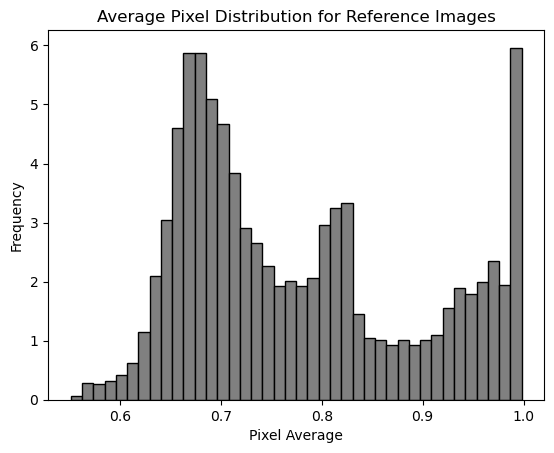

In [338]:
plt.hist(flat_ref, bins=40, color='grey', edgecolor='black', density = True)
 
# Adding labels and title
plt.xlabel('Pixel Average')
plt.ylabel('Frequency')
plt.title('Average Pixel Distribution for Reference Images')
 
# Display the plot
plt.show()

In [335]:
flat_crop = mean_crop.flatten()

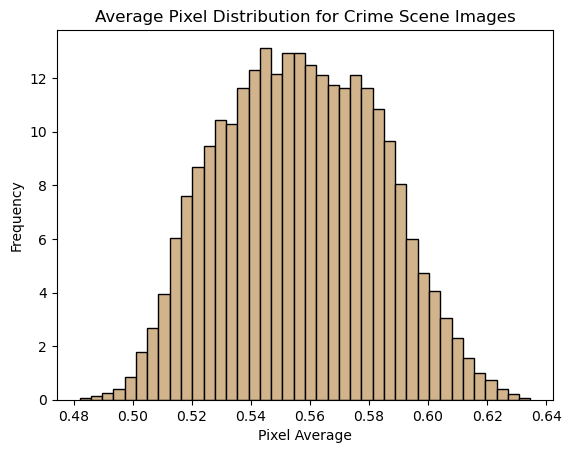

In [337]:
plt.hist(flat_crop, bins=40, color='tan', edgecolor='black', density = True)
 
# Adding labels and title
plt.xlabel('Pixel Average')
plt.ylabel('Frequency')
plt.title('Average Pixel Distribution for Crime Scene Images')
 
# Display the plot
plt.show()

### Data preprocessing

In [123]:
#Resizes an image. Takes in an image path and returns an array
def resize_img(imgpath):
    img = cv2.imread(imgpath)
    resized_img = cv2.resize(img, (200, 200))
    img_arr = np.array(resized_img)
    return img_arr

In [124]:
#Takes an image path and returns a random cropped patch of that image in the form of an array
def crop_patch(imgpath):
    ph = 97
    pw = 97
    img = Image.open(imgpath)
    img_arr = np.array(img)
    
    
    cord_list = find_patch_cord(imgpath)
    patch_arr = cord_list[2]
    crop_patch = img_arr[y_cord:y_cord+ph, x_cord:x_cord+pw]
        
    arr = np.array(crop_patch)
    return arr

In [125]:
#Passes in a image path and returns a random patch of that image resized to 200, 200
def crop_resize(imgpath):
    
    img = cv2.imread(imgpath)
    img_arr = np.array(img)
    
    patch_arr = random_patch(img_arr)
    patch = Image.fromarray(patch_arr)
    
    patch_scr = np.array(patch)
    resized_img = cv2.resize(patch_scr, (200, 200))
    patch_arr_resized = np.array(resized_img)
    
    return patch_arr_resized

### Creating Test and Train Data

1) Create data with references and reference patch split by 80/20 into test and train and run model with x_train and y_train, with 1 epoch and 1 batch size 
2) Create date with reference and crime scene split by 80/20 into test and train and run model with x_train and y_train with 1 epoch and 1 batch size.

#### 1) Reference patch and reference 

In [107]:
df_match = pd.merge(filenames_ref, filenames_ref, right_index = True, left_index = True)
df_match.head()

reference_x  \
0  /home/jovyan/work/Fid300/FID-300/references/01...   
1  /home/jovyan/work/Fid300/FID-300/references/00...   
2  /home/jovyan/work/Fid300/FID-300/references/00...   
3  /home/jovyan/work/Fid300/FID-300/references/00...   
4  /home/jovyan/work/Fid300/FID-300/references/00...   

                                         reference_y  
0  /home/jovyan/work/Fid300/FID-300/references/01...  
1  /home/jovyan/work/Fid300/FID-300/references/00...  
2  /home/jovyan/work/Fid300/FID-300/references/00...  
3  /home/jovyan/work/Fid300/FID-300/references/00...  
4  /home/jovyan/work/Fid300/FID-300/references/00...

In [108]:
df_match['label'] = 1
df_match
df_match.columns = ['reference', 'reference', 'label'] 
df_match.head()

reference  \
0  /home/jovyan/work/Fid300/FID-300/references/01...   
1  /home/jovyan/work/Fid300/FID-300/references/00...   
2  /home/jovyan/work/Fid300/FID-300/references/00...   
3  /home/jovyan/work/Fid300/FID-300/references/00...   
4  /home/jovyan/work/Fid300/FID-300/references/00...   

                                           reference  label  
0  /home/jovyan/work/Fid300/FID-300/references/01...      1  
1  /home/jovyan/work/Fid300/FID-300/references/00...      1  
2  /home/jovyan/work/Fid300/FID-300/references/00...      1  
3  /home/jovyan/work/Fid300/FID-300/references/00...      1  
4  /home/jovyan/work/Fid300/FID-300/references/00...      1

In [109]:
match_list_ref = df_match.values.tolist()
match_list_ref[0:2]

[['/home/jovyan/work/Fid300/FID-300/references/01019.png',
  '/home/jovyan/work/Fid300/FID-300/references/01019.png',
  1],
 ['/home/jovyan/work/Fid300/FID-300/references/00073.png',
  '/home/jovyan/work/Fid300/FID-300/references/00073.png',
  1]]

In [110]:
lst = filenames_ref.values.tolist()

def myfunction():
    return 0.1
random.shuffle(lst)

1175

In [111]:
df_shuffed = pd.DataFrame(lst)

In [112]:
df_unmatched = pd.merge(filenames_ref, df_shuffed, right_index = True, left_index = True)
df_unmatched['label'] = 0
df_unmatched.columns = ['reference', 'reference', 'label']  

In [113]:
unmatch_list_ref = df_unmatched.values.tolist()
unmatch_list_ref[0:4]

[['/home/jovyan/work/Fid300/FID-300/references/01019.png',
  '/home/jovyan/work/Fid300/FID-300/references/00835.png',
  0],
 ['/home/jovyan/work/Fid300/FID-300/references/00073.png',
  '/home/jovyan/work/Fid300/FID-300/references/00676.png',
  0],
 ['/home/jovyan/work/Fid300/FID-300/references/00295.png',
  '/home/jovyan/work/Fid300/FID-300/references/00233.png',
  0],
 ['/home/jovyan/work/Fid300/FID-300/references/00031.png',
  '/home/jovyan/work/Fid300/FID-300/references/00025.png',
  0]]

In [114]:
total_lst = unmatch_list_ref + match_list_ref
random.shuffle(total_lst)
total_lst[0:10]

[['/home/jovyan/work/Fid300/FID-300/references/00307.png',
  '/home/jovyan/work/Fid300/FID-300/references/00307.png',
  1],
 ['/home/jovyan/work/Fid300/FID-300/references/00286.png',
  '/home/jovyan/work/Fid300/FID-300/references/00326.png',
  0],
 ['/home/jovyan/work/Fid300/FID-300/references/00718.png',
  '/home/jovyan/work/Fid300/FID-300/references/00718.png',
  1],
 ['/home/jovyan/work/Fid300/FID-300/references/00279.png',
  '/home/jovyan/work/Fid300/FID-300/references/00137.png',
  0],
 ['/home/jovyan/work/Fid300/FID-300/references/00023.png',
  '/home/jovyan/work/Fid300/FID-300/references/00534.png',
  0],
 ['/home/jovyan/work/Fid300/FID-300/references/00150.png',
  '/home/jovyan/work/Fid300/FID-300/references/00150.png',
  1],
 ['/home/jovyan/work/Fid300/FID-300/references/00123.png',
  '/home/jovyan/work/Fid300/FID-300/references/00123.png',
  1],
 ['/home/jovyan/work/Fid300/FID-300/references/01162.png',
  '/home/jovyan/work/Fid300/FID-300/references/00318.png',
  0],
 ['/home

In [115]:
len(total_lst) 

2350

In [174]:
X = np.zeros((len(total_lst), 2, 200, 200, 3))
y = np.zeros(len(total_lst))

In [129]:
s = crop_resize(references[0])
s.shape

(200, 200)

In [130]:
resize_img(references[0]).shape

(200, 200, 3)

In [175]:
#reference to reference
for i,triplet in enumerate(total_lst):
    X[i][0] = crop_resize(triplet[0])
    X[i][1] = resize_img(triplet[1]) # foo2 will only resize
    y[i] = triplet[2] 
    if (i % 100 == 0):
        print(i)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300


In [115]:
X_c = np.zeros((len(crime_ref_lst), 2, 200, 200, 3))
y_c = np.zeros(len(crime_ref_lst))

In [127]:
#crime to reference
for i,triplet in enumerate(crime_ref_lst):
    X_c[i][0] = resize_img(triplet[0]) #crime
    X_c[i][1] = resize_img(triplet[1]) #reference
    y_c[i] = triplet[2] #label

0
100
200
300
400
500


#### 2) Crime scene and reference

Save crime to ref

In [129]:
with open('X_c.npy', 'wb') as f:
    np.save(f, X_c)

In [130]:
with open('y_c.npy', 'wb') as f:
    np.save(f, y_c)

Save ref to ref

In [176]:
with open('X.npy', 'wb') as f:
    np.save(f, X)

In [177]:
with open('y.npy', 'wb') as f:
    np.save(f, y)

Use this to open the saved x and y

In [372]:
with open('X_c.npy', 'rb') as f:
    X = np.load(f)
    
with open('y_c.npy', 'rb') as f:
    y = np.load(f)    

Create x and y train and test data

In [373]:
X_train, X_test, y_train, y_test = train_test_split(X_c, y_c, test_size=0.2, random_state=42)

In [374]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((480, 2, 200, 200, 3), (120, 2, 200, 200, 3), (480,), (120,))

#### Siamese Neural Network Implementation: Contrastive Loss

Code used from: https://keras.io/examples/vision/siamese_contrastive/

In [375]:
def visualize(pairs, labels, to_show=6, num_col=3, predictions=None, test=False):
    """Creates a plot of pairs and labels, and prediction if it's test dataset.

    Arguments:
        pairs: Numpy Array, of pairs to visualize, having shape
               (Number of pairs, 2, 200, 200).
        to_show: Int, number of examples to visualize (default is 6)
                `to_show` must be an integral multiple of `num_col`.
                 Otherwise it will be trimmed if it is greater than num_col,
                 and incremented if if it is less then num_col.
        num_col: Int, number of images in one row - (default is 3)
                 For test and train respectively, it should not exceed 3 and 7.
        predictions: Numpy Array of predictions with shape (to_show, 1) -
                     (default is None)
                     Must be passed when test=True.
        test: Boolean telling whether the dataset being visualized is
              train dataset or test dataset - (default False).

    Returns:
        None.
    """

    # Define num_row
    # If to_show % num_col != 0
    #    trim to_show,
    #       to trim to_show limit num_row to the point where
    #       to_show % num_col == 0
    #
    # If to_show//num_col == 0
    #    then it means num_col is greater then to_show
    #    increment to_show
    #       to increment to_show set num_row to 1
    num_row = to_show // num_col if to_show // num_col != 0 else 1

    # `to_show` must be an integral multiple of `num_col`
    #  we found num_row and we have num_col
    #  to increment or decrement to_show
    #  to make it integral multiple of `num_col`
    #  simply set it equal to num_row * num_col
    to_show = num_row * num_col

    # Plot the images
    fig, axes = plt.subplots(num_row, num_col, figsize=(5, 5))
    for i in range(to_show):
        # If the number of rows is 1, the axes array is one-dimensional
        if num_row == 1:
            ax = axes[i % num_col]
        else:
            ax = axes[i // num_col, i % num_col]

        ax.imshow(np.concatenate([pairs[i][0], pairs[i][1]], axis=1).astype(np.uint8), cmap="gray")
        ax.set_axis_off()
        if test:
            ax.set_title("True: {} | Pred: {:.5f}".format(labels[i], predictions[i][0]))
        else:
            ax.set_title("Label: {}".format(labels[i]))
    if test:
        plt.tight_layout(rect=(0, 0, 1.9, 1.9), w_pad=0.0)
    else:
        plt.tight_layout(rect=(0, 0, 1.5, 1.5))
    plt.show()

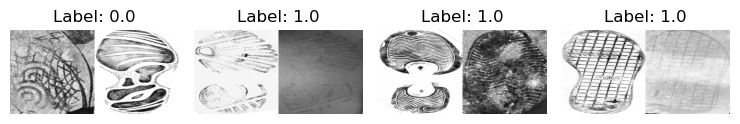

In [376]:
visualize(X_train[:-1], y_train[:-1], to_show=4, num_col=4)

In [377]:
target_shape = (200, 200, 3)

In [378]:
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((y_train, y_test), axis=0)
kfold = KFold(n_splits=5, random_state=1, shuffle=True)

In [379]:
inputs.shape

(600, 2, 200, 200, 3)

In [380]:
targets.shape

(600,)

In [381]:
def euclidean_distance(vects):
    """Find the Euclidean distance between two vectors.

    Arguments:
        vects: List containing two tensors of same length.

    Returns:
        Tensor containing euclidean distance
        (as floating point value) between vectors.
    """

    x, y = vects
    sum_square = ops.sum(ops.square(x - y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, keras.backend.epsilon()))

In [382]:
# Provided two tensors t1 and t2
# Euclidean distance = sqrt(sum(square(t1-t2)))

kfold_nums = 1
acc_per_fold = []
loss_per_fold = []

#model start
for train, test in kfold.split(inputs, targets):
    base_cnn = resnet.ResNet50(
        weights="imagenet", input_shape=target_shape, include_top=False
    )
    flatten = layers.Flatten()(base_cnn.output)
    dense1 = layers.Dense(512, activation="relu")(flatten)
    dense1 = layers.BatchNormalization()(dense1)
    dense2 = layers.Dense(256, activation="relu")(dense1)
    dense2 = layers.BatchNormalization()(dense2)
    output = layers.Dense(256)(dense2)

    embedding_network = Model(base_cnn.input, output, name="Embedding")

    trainable = False
    for layer in base_cnn.layers:
        if layer.name == "conv5_block1_out":
            trainable = True
        layer.trainable = trainable


    input_1 = keras.layers.Input((200, 200, 3))
    input_2 = keras.layers.Input((200, 200, 3))

    # As mentioned above, Siamese Network share weights between
    # tower networks (sister networks). To allow this, we will use
    # same embedding network for both tower networks.
    tower_1 = embedding_network(input_1)
    tower_2 = embedding_network(input_2)

    merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))(
        [tower_1, tower_2]
    )
    normal_layer = keras.layers.BatchNormalization()(merge_layer)
    output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)
    siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)
    

    siamese.compile(loss=loss(margin=1), optimizer="RMSprop", metrics=["accuracy"])
    
    
    history = siamese.fit(
        [inputs[train][:,0], inputs[train][:,1]],
        targets[train],
        batch_size=batch_size,
        epochs=epochs,
    )
    
    scores = siamese.evaluate([inputs[test][:,0], inputs[test][:,1]], targets[test])
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    kfold_nums = kfold_nums + 1
    
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Epoch 1/10
 5/30 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4383 - loss: 0.3092

W0000 00:00:1709076048.680539 3121161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - accuracy: 0.5339 - loss: 0.2743
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6588 - loss: 0.2193
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7953 - loss: 0.1725
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9033 - loss: 0.1230
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9482 - loss: 0.0959
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9389 - loss: 0.1006
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9611 - loss: 0.0794
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9850 - loss: 0.0651
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9617 - loss: 0.0778
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9903 - loss: 0.0597
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7569 - loss: 0.1959

W0000 00:00:1709076063.529189 3121162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 691ms/step - accuracy: 0.7508 - loss: 0.1972


W0000 00:00:1709076065.600796 3121158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/10
 5/30 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5190 - loss: 0.3050

W0000 00:00:1709076082.080411 3121161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.5267 - loss: 0.2815
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7826 - loss: 0.1656
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8599 - loss: 0.1473
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8749 - loss: 0.1232
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9357 - loss: 0.1062
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8981 - loss: 0.1053
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9693 - loss: 0.0766
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9583 - loss: 0.0768
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9889 - loss: 0.0640
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9641 - loss: 0.0657
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6840 - loss: 0.2340

W0000 00:00:1709076096.704669 3121160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 695ms/step - accuracy: 0.6571 - loss: 0.2385


W0000 00:00:1709076098.785929 3121162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/10
 5/30 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6494 - loss: 0.2369

W0000 00:00:1709076115.220263 3121157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.5966 - loss: 0.2422
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6445 - loss: 0.2276
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7493 - loss: 0.2014
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8195 - loss: 0.1773
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9157 - loss: 0.1607
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9157 - loss: 0.1539
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9545 - loss: 0.1370
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9808 - loss: 0.1233
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9901 - loss: 0.1142
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9738 - loss: 0.1121
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.7465 - loss: 0.2000

W0000 00:00:1709076129.816365 3121157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 688ms/step - accuracy: 0.7312 - loss: 0.2026


W0000 00:00:1709076131.879312 3121162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/10
 5/30 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6215 - loss: 0.2307

W0000 00:00:1709076148.362616 3121162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.5459 - loss: 0.2452
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6893 - loss: 0.2220
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8294 - loss: 0.2000
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9433 - loss: 0.1791
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9711 - loss: 0.1696
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9764 - loss: 0.1607
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9794 - loss: 0.1561
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9893 - loss: 0.1430
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9853 - loss: 0.1393
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9755 - loss: 0.1320
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.6181 - loss: 0.2404

W0000 00:00:1709076165.740546 3121161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 693ms/step - accuracy: 0.6108 - loss: 0.2373


W0000 00:00:1709076167.818357 3121161 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Epoch 1/10
 5/30 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3960 - loss: 0.2718

W0000 00:00:1709076184.655582 3121157 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


30/30 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.4532 - loss: 0.2619
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6095 - loss: 0.2336
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.8319 - loss: 0.2085
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.8874 - loss: 0.1933
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9193 - loss: 0.1835
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9349 - loss: 0.1749
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9423 - loss: 0.1666
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9723 - loss: 0.1531
Epoch 9/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9750 - loss: 0.1443
Epoch 10/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.9429 - loss: 0.1442
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6128 - loss: 0.2168

W0000 00:00:1709076199.244899 3121162 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 697ms/step - accuracy: 0.6010 - loss: 0.2233
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.19918116927146912 - Accuracy: 74.16666746139526%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.2453044056892395 - Accuracy: 61.666667461395264%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.20661896467208862 - Accuracy: 70.83333134651184%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.232548326253891 - Accuracy: 60.00000238418579%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.2331555336713791 - Accuracy: 58.33333134651184%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 65.0 (+- 6.30255662176

W0000 00:00:1709076201.331727 3121158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


W0000 00:00:1709076205.705504 3121160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


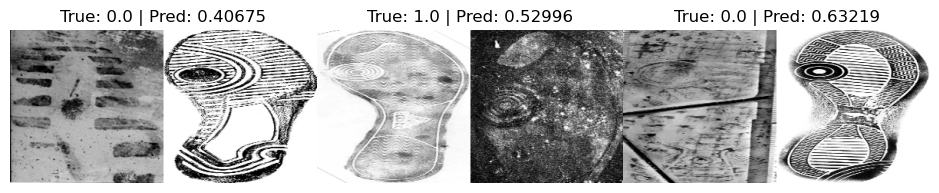

In [383]:
predictions = siamese.predict([inputs[0:5, 0], inputs[0:5, 1]])
visualize(X_test, y_test, to_show=3, predictions=predictions, test=True)

In [384]:
def loss(margin=1):
    """Provides 'contrastive_loss' an enclosing scope with variable 'margin'.

    Arguments:
        margin: Integer, defines the baseline for distance for which pairs
                should be classified as dissimilar. - (default is 1).

    Returns:
        'contrastive_loss' function with data ('margin') attached.
    """

    # Contrastive loss = mean( (1-true_value) * square(prediction) +
    #                         true_value * square( max(margin-prediction, 0) ))
    def contrastive_loss(y_true, y_pred):
        """Calculates the contrastive loss.

        Arguments:
            y_true: List of labels, each label is of type float32.
            y_pred: List of predictions of same length as of y_true,
                    each label is of type float32.

        Returns:
            A tensor containing contrastive loss as floating point value.
        """

        square_pred = ops.square(y_pred)
        margin_square = ops.square(ops.maximum(margin - (y_pred), 0))
        return ops.mean((1 - y_true) * square_pred + (y_true) * margin_square)

    return contrastive_loss

KeyError: 'val_accuracy'

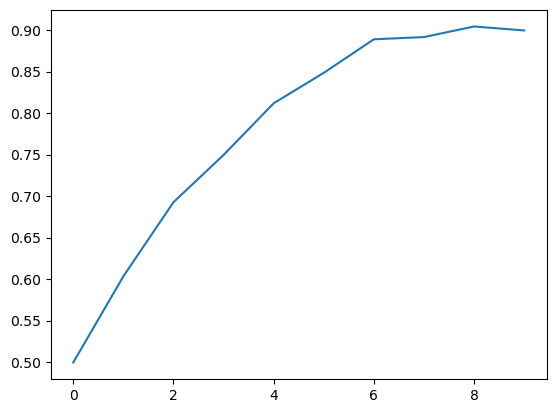

In [371]:
def plt_metric(history, metric, title, has_valid=True):
    """Plots the given 'metric' from 'history'.

    Arguments:
        history: history attribute of History object returned from Model.fit.
        metric: Metric to plot, a string value present as key in 'history'.
        title: A string to be used as title of plot.
        has_valid: Boolean, true if valid data was passed to Model.fit else false.

    Returns:
        None.
    """
    plt.plot(history[metric])
    if has_valid:
        plt.plot(history["val_" + metric])
        plt.legend(["train", "validation"], loc="upper left")
    plt.title(title)
    plt.ylabel(metric)
    plt.xlabel("epoch")
    plt.show()


# Plot the accuracy
plt_metric(history=history.history, metric="accuracy", title="Model accuracy")

# Plot the contrastive loss
plt_metric(history=history.history, metric="loss", title="Contrastive Loss")

In [151]:
results = siamese.evaluate([X_test[:,0], X_test[:,1]], y_test)
print("test loss, test acc:", results)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7006 - loss: 0.1853
test loss, test acc: [0.18358087539672852, 0.6916666626930237]


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


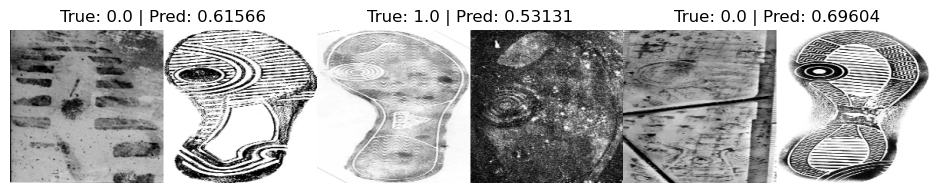

In [152]:
predictions = siamese.predict([X_test[:, 0], X_test[:, 1]])
visualize(X_test, y_test, to_show=3, predictions=predictions, test=True)

#### 2) Crime scene and Reference 

In [25]:
labels.head()

cropped  reference
0        1       1044
1        2         14
2        3       1052
3        4       1078
4        5         63

In [58]:
cropped_str = labels["cropped"].astype("string")

In [73]:
lst_crop = []
for i in range(len(cropped_str)):
    string = "/home/jovyan/work/Fid300/FID-300/tracks_cropped/"+ cropped_str[i].zfill(5) + ".jpg"
    lst_crop.append(string)

In [74]:
lst_crop

['/home/jovyan/work/Fid300/FID-300/tracks_cropped/00001.jpg',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00002.jpg',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00003.jpg',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00004.jpg',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00005.jpg',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00006.jpg',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00007.jpg',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00008.jpg',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00009.jpg',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00010.jpg',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00011.jpg',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00012.jpg',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00013.jpg',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00014.jpg',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00015.jpg',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00016.jpg',
 '/home/

In [71]:
ref_str = labels["reference"].astype("string")

In [77]:
lst_ref = []
for i in range(len(ref_str)):
    string = "/home/jovyan/work/Fid300/FID-300/references/" + ref_str[i].zfill(5) + ".png"
    lst_ref.append(string)

In [76]:
lst_ref

['/home/jovyan/work/Fid300/FID-300/tracks_cropped/01044.png',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00014.png',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/01052.png',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/01078.png',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00063.png',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00011.png',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00039.png',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/01050.png',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00003.png',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00037.png',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00037.png',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00014.png',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00014.png',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/01056.png',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/01064.png',
 '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00012.png',
 '/home/

In [ ]:
filenames_ref = pd.DataFrame({'reference' : references})

In [189]:
# matches
df_final = pd.DataFrame({'references' : lst_ref, 'cropped' : lst_crop, 'unmatched_ref' : random.sample(references, 300)})

df_final.head()

references  \
0  /home/jovyan/work/Fid300/FID-300/references/01...   
1  /home/jovyan/work/Fid300/FID-300/references/00...   
2  /home/jovyan/work/Fid300/FID-300/references/01...   
3  /home/jovyan/work/Fid300/FID-300/references/01...   
4  /home/jovyan/work/Fid300/FID-300/references/00...   

                                             cropped  \
0  /home/jovyan/work/Fid300/FID-300/tracks_croppe...   
1  /home/jovyan/work/Fid300/FID-300/tracks_croppe...   
2  /home/jovyan/work/Fid300/FID-300/tracks_croppe...   
3  /home/jovyan/work/Fid300/FID-300/tracks_croppe...   
4  /home/jovyan/work/Fid300/FID-300/tracks_croppe...   

                                       unmatched_ref  
0  /home/jovyan/work/Fid300/FID-300/references/00...  
1  /home/jovyan/work/Fid300/FID-300/references/01...  
2  /home/jovyan/work/Fid300/FID-300/references/01...  
3  /home/jovyan/work/Fid300/FID-300/references/00...  
4  /home/jovyan/work/Fid300/FID-300/references/01...

In [107]:
ref_rand = random.sample(references, 300)
crop_rand = random.sample(tracks_cropped, 300)

In [108]:
#unmatches 
df_unmatched = pd.DataFrame({'cropped': crop_rand, 'references': ref_rand, 'label' :[0] * len(ref_rand)})
df_unmatched.head()

cropped  \
0  /home/jovyan/work/Fid300/FID-300/tracks_croppe...   
1  /home/jovyan/work/Fid300/FID-300/tracks_croppe...   
2  /home/jovyan/work/Fid300/FID-300/tracks_croppe...   
3  /home/jovyan/work/Fid300/FID-300/tracks_croppe...   
4  /home/jovyan/work/Fid300/FID-300/tracks_croppe...   

                                          references  label  
0  /home/jovyan/work/Fid300/FID-300/references/00...      0  
1  /home/jovyan/work/Fid300/FID-300/references/00...      0  
2  /home/jovyan/work/Fid300/FID-300/references/00...      0  
3  /home/jovyan/work/Fid300/FID-300/references/00...      0  
4  /home/jovyan/work/Fid300/FID-300/references/00...      0

In [112]:
unmatch_lst = df_unmatched.values.tolist()
matched_lst = df_matched.values.tolist()

crime_ref_lst = unmatch_lst + matched_lst


['/home/jovyan/work/Fid300/FID-300/tracks_cropped/00107.jpg',
 '/home/jovyan/work/Fid300/FID-300/references/00774.png',
 0]

In [113]:
random.shuffle(crime_ref_lst)

In [114]:
crime_ref_lst

[['/home/jovyan/work/Fid300/FID-300/references/00863.png',
  '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00050.jpg',
  1],
 ['/home/jovyan/work/Fid300/FID-300/references/00004.png',
  '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00267.jpg',
  1],
 ['/home/jovyan/work/Fid300/FID-300/references/00033.png',
  '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00023.jpg',
  1],
 ['/home/jovyan/work/Fid300/FID-300/references/00017.png',
  '/home/jovyan/work/Fid300/FID-300/tracks_cropped/00275.jpg',
  1],
 ['/home/jovyan/work/Fid300/FID-300/tracks_cropped/00221.jpg',
  '/home/jovyan/work/Fid300/FID-300/references/00452.png',
  0],
 ['/home/jovyan/work/Fid300/FID-300/tracks_cropped/00272.jpg',
  '/home/jovyan/work/Fid300/FID-300/references/00584.png',
  0],
 ['/home/jovyan/work/Fid300/FID-300/tracks_cropped/00140.jpg',
  '/home/jovyan/work/Fid300/FID-300/references/00498.png',
  0],
 ['/home/jovyan/work/Fid300/FID-300/tracks_cropped/00176.jpg',
  '/home/jovyan/work/Fid300/FID-300/refer

### Triplet Siamese Network

Code from: https://keras.io/examples/vision/siamese_network/

In [480]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [481]:
target_shape = (200, 200)

In [482]:
image_count = len(df_final)

In [483]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(df_final["cropped"])
positive_dataset = tf.data.Dataset.from_tensor_slices(df_final["references"])
negative_dataset = tf.data.Dataset.from_tensor_slices(df_final["unmatched_ref"])

In [484]:
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and validation.
train_val_dataset = dataset.take(round(image_count * 0.8))
test_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_val_dataset.take(round(image_count * 0.8))
val_dataset = train_val_dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.batch(32, drop_remainder=False)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

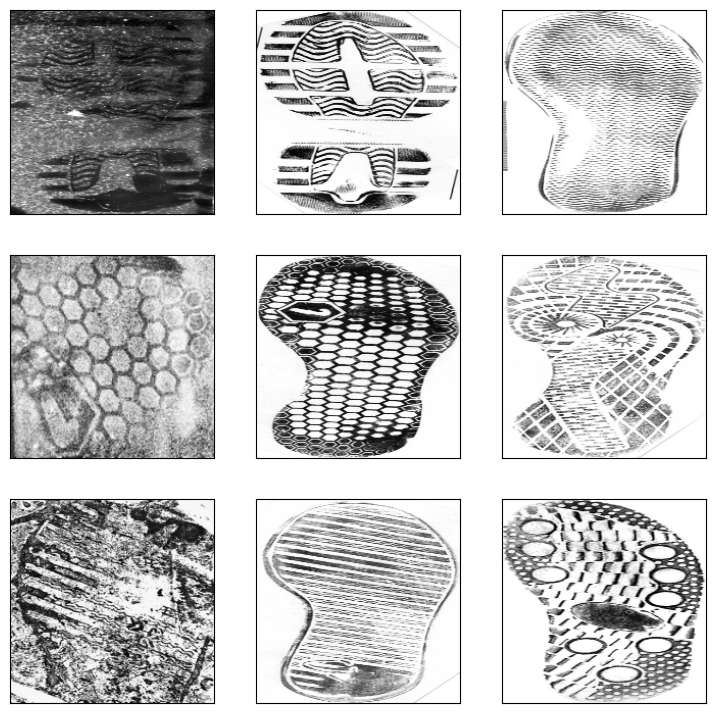

In [485]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [486]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable


In [487]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = ops.sum(tf.square(anchor - positive), -1)
        an_distance = ops.sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [488]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]


In [489]:
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
3/8 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 2.8590

W0000 00:00:1709171897.741138 3121160 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step - loss: 2.2090

W0000 00:00:1709171903.975691 3121158 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


8/8 ━━━━━━━━━━━━━━━━━━━━ 31s 1s/step - loss: 2.1354 - val_loss: 0.0000e+00
Epoch 2/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - loss: 0.2393

2024-02-29 01:58:27.155797: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3123845388046374933
2024-02-29 01:58:27.155852: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7571805410282706138
2024-02-29 01:58:27.155899: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5476513378908262767
/opt/conda/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.2837 - val_loss: 0.0000e+00
Epoch 3/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.1169

2024-02-29 01:58:27.882854: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3123845388046374933
2024-02-29 01:58:27.882906: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7571805410282706138
2024-02-29 01:58:27.882948: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5476513378908262767


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.1508 - val_loss: 0.0000e+00
Epoch 4/10


2024-02-29 01:58:28.612333: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3123845388046374933
2024-02-29 01:58:28.612385: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7571805410282706138
2024-02-29 01:58:28.612434: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5476513378908262767


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0893 - val_loss: 0.0000e+00
Epoch 5/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0715

2024-02-29 01:58:29.390571: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3123845388046374933
2024-02-29 01:58:29.390623: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7571805410282706138
2024-02-29 01:58:29.390668: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5476513378908262767


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0674 - val_loss: 0.0000e+00
Epoch 6/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - loss: 0.0705

2024-02-29 01:58:30.091040: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3123845388046374933
2024-02-29 01:58:30.091090: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7571805410282706138
2024-02-29 01:58:30.091128: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5476513378908262767


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0762 - val_loss: 0.0000e+00
Epoch 7/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 1s 150ms/step - loss: 0.0215

2024-02-29 01:58:30.789194: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3123845388046374933
2024-02-29 01:58:30.789246: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7571805410282706138
2024-02-29 01:58:30.789290: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5476513378908262767


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0321 - val_loss: 0.0000e+00
Epoch 8/10
1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 4.0740e-04

2024-02-29 01:58:31.518515: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3123845388046374933
2024-02-29 01:58:31.518566: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7571805410282706138
2024-02-29 01:58:31.518610: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5476513378908262767


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0185 - val_loss: 0.0000e+00
Epoch 9/10
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 0.0317 

2024-02-29 01:58:32.224514: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3123845388046374933
2024-02-29 01:58:32.224564: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7571805410282706138
2024-02-29 01:58:32.224611: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5476513378908262767


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0285 - val_loss: 0.0000e+00
Epoch 10/10
2/8 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0117 

2024-02-29 01:58:32.962776: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3123845388046374933
2024-02-29 01:58:32.962830: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7571805410282706138
2024-02-29 01:58:32.962874: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5476513378908262767


8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0208 - val_loss: 0.0000e+00


2024-02-29 01:58:33.650052: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3123845388046374933
2024-02-29 01:58:33.650101: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7571805410282706138
2024-02-29 01:58:33.650148: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 5476513378908262767


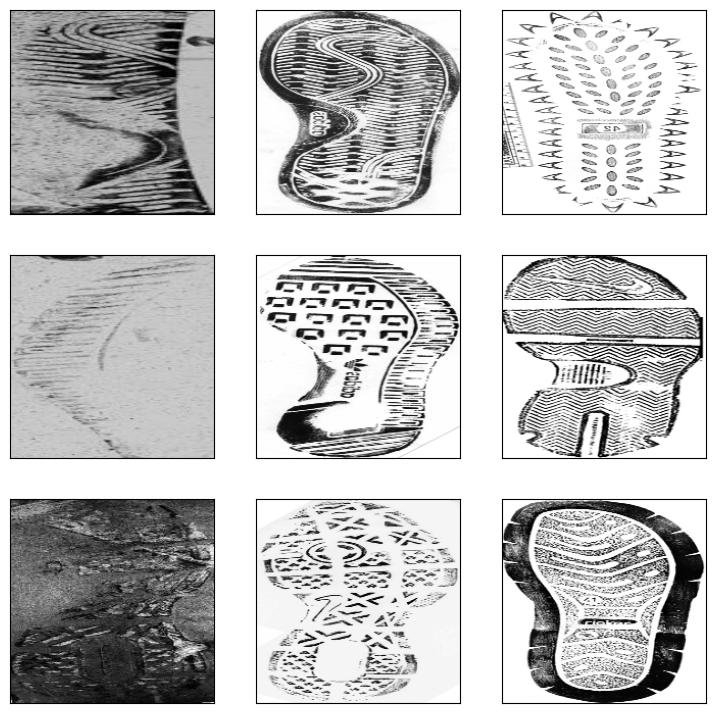

In [490]:
sample = next(iter(test_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)

In [491]:
def my_cosine_similarity(anchor_embedding, positive_embedding):
    return ops.sum(ops.multiply(anchor_embedding, positive_embedding), axis=1) / (ops.sqrt(ops.sum(ops.square(anchor_embedding), axis=1)) * ops.sqrt(ops.sum(ops.square(positive_embedding), axis=1)))

In [492]:
cosine_similarity = metrics.CosineSimilarity()

positive_similarity = my_cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = my_cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: [0.9973622  0.99828917 0.99737936 0.9969792  0.9965773  0.99616736
 0.99353755 0.9881927  0.9967136  0.99625725 0.9977034  0.9991741
 0.99808717 0.9930673  0.9985512  0.9963656  0.9962053  0.99586624
 0.99744093 0.9980993  0.9976283  0.99730945 0.99691576 0.9937991
 0.9986923  0.997478   0.9989209  0.99638087 0.99847865 0.9989489
 0.99824184 0.99931574]
Negative similarity [0.9946772  0.99463665 0.98008424 0.99086237 0.9923374  0.9715816
 0.98213816 0.98258543 0.9956478  0.99103963 0.99308395 0.97211313
 0.99440295 0.9865313  0.9958296  0.9778406  0.97866005 0.9812439
 0.9942152  0.98442644 0.9955597  0.99232805 0.99235815 0.99499005
 0.9933312  0.9847569  0.99085796 0.9980673  0.9925302  0.9907797
 0.98848635 0.9921798 ]


In [493]:
all_positive = []
all_negative = []
for sample in test_dataset:

    anchor, positive, negative = sample
    anchor_embedding, positive_embedding, negative_embedding = (
        embedding(resnet.preprocess_input(anchor)),
        embedding(resnet.preprocess_input(positive)),
        embedding(resnet.preprocess_input(negative)),
    )
    
    positive_similarity = my_cosine_similarity(anchor_embedding, positive_embedding)
    print("Positive similarity:", positive_similarity.numpy())

    negative_similarity = my_cosine_similarity(anchor_embedding, negative_embedding)
    print("Negative similarity", negative_similarity.numpy())
    
    all_positive.append(positive_similarity)
    all_negative.append(negative_similarity)

Positive similarity: [0.99446887 0.9947521  0.99814934 0.9947015  0.9969792  0.99794483
 0.99809563 0.9977656  0.99824184 0.9970529  0.99703246 0.9981209
 0.99675494 0.9952697  0.99730945 0.9971743  0.9977302  0.9982772
 0.99681306 0.99574476 0.99779457 0.99847865 0.9995661  0.9969777
 0.9974383  0.993426   0.9977885  0.9977034  0.9978222  0.99927026
 0.9979236  0.9985512 ]
Negative similarity [0.99382675 0.99199575 0.98681414 0.9645765  0.99086237 0.99627805
 0.9923434  0.99316204 0.98848635 0.989148   0.99110675 0.9933549
 0.98564065 0.9781238  0.99232805 0.9750433  0.98983973 0.99386644
 0.9960322  0.9932866  0.99340415 0.9925302  0.9886115  0.9933353
 0.9804425  0.993426   0.9976298  0.99308395 0.9948453  0.9992446
 0.99626577 0.9958296 ]
Positive similarity: [0.99851    0.99795526 0.9969375  0.9972878  0.9954786  0.9947827
 0.99425626 0.9963112  0.9973799  0.9980744  0.9971687  0.9976264
 0.997363   0.9881916  0.99640054 0.9973477  0.99756837 0.9969287
 0.9995187  0.9934099  0.997

In [494]:
np.sum(all_positive[0] > all_negative[0]) + np.sum(all_positive[1] > all_negative[1])

58

In [495]:
image_count * 0.2

60.0

In [497]:
58/60

0.9666666666666667

### siftCV2

Code from: https://github.com/zszazi/OpenCV-Template-matching-and-SIFT

In [ ]:
img = cv2.imread('',0)
img2 = img.copy()
template = cv2.imread('crop.jpg',0)
w, h = template.shape[::-1]

print('-----------------------IMAGE-----------------------')
cv2_imshow(img)

print('\n-----------------------TEMPLATE-----------------------')
cv2_imshow(template)



In [454]:
np.sum(crime_img_arr[3])

80569.39490817554

In [511]:
i = 0
j = 0
for sample in test_dataset:
    anchor, positive, negative = sample
    for crime in anchor: 
        crime_img_arr[i] = crime
        i+=1
    
    for ref in positive:
        ref_img_arr[j] = ref
        j+=1
    

In [510]:
ref_img_arr = np.zeros((60, 200, 200, 3))
crime_img_arr = np.zeros((60, 200, 200, 3))

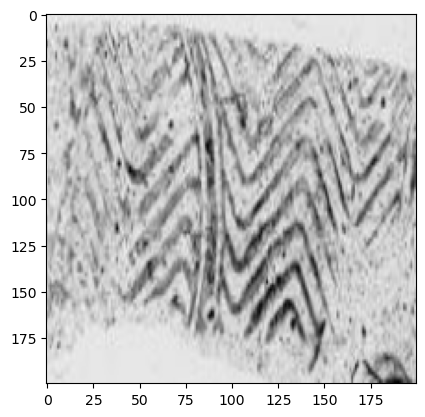

In [515]:
plt.imshow(crime_img_arr[3])

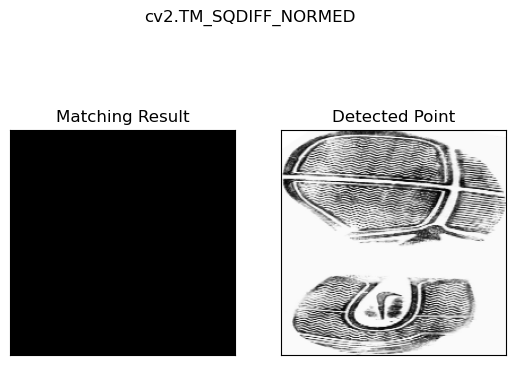

0.0 0.0 (0, 0) (0, 0)


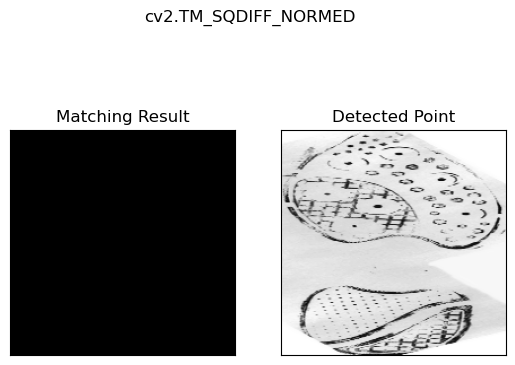

0.0 0.0 (0, 0) (0, 0)


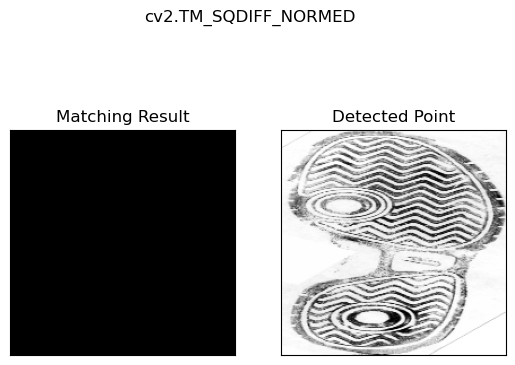

0.0 0.0 (0, 0) (0, 0)


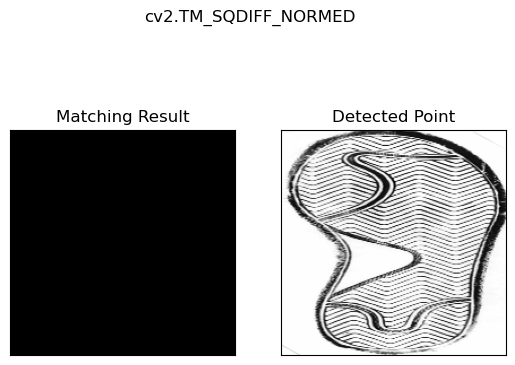

3.7655137674619255e-08 3.7655137674619255e-08 (0, 0) (0, 0)


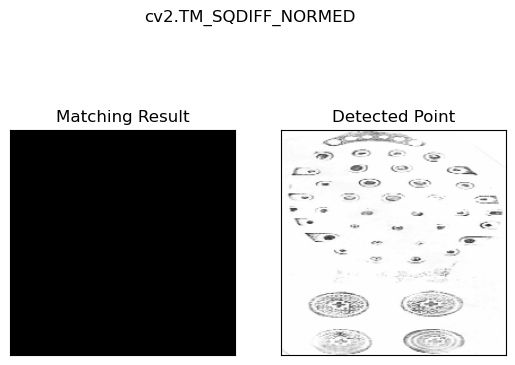

0.0 0.0 (0, 0) (0, 0)


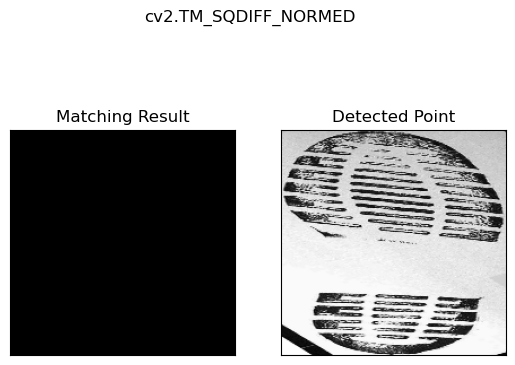

0.0 0.0 (0, 0) (0, 0)


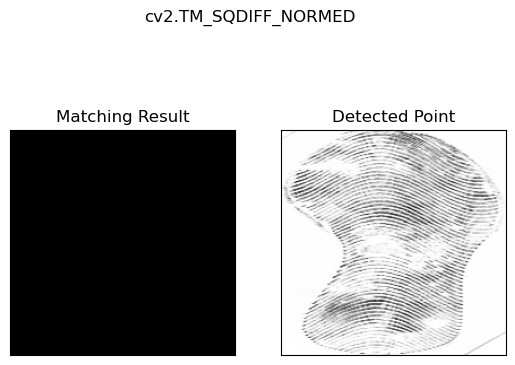

3.855512886730139e-08 3.855512886730139e-08 (0, 0) (0, 0)


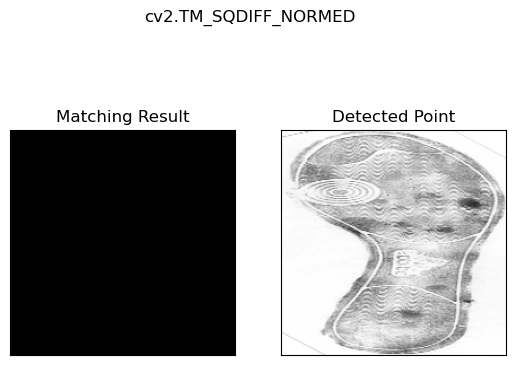

0.0 0.0 (0, 0) (0, 0)


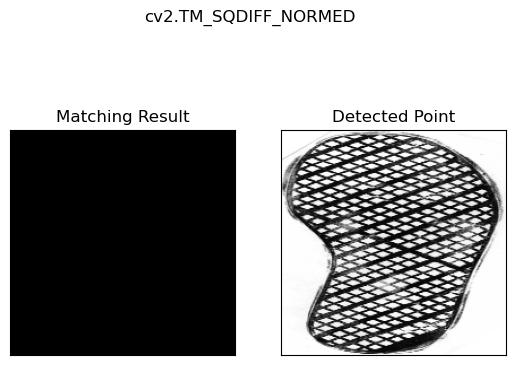

0.0 0.0 (0, 0) (0, 0)


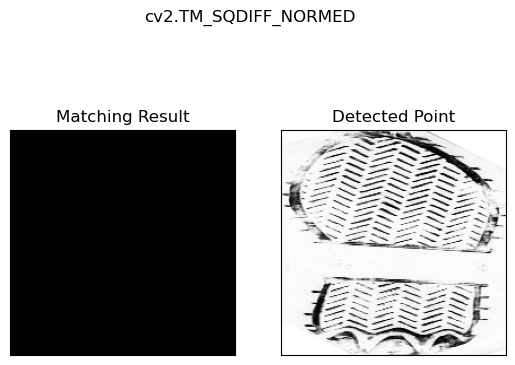

2.4918277219398988e-08 2.4918277219398988e-08 (0, 0) (0, 0)


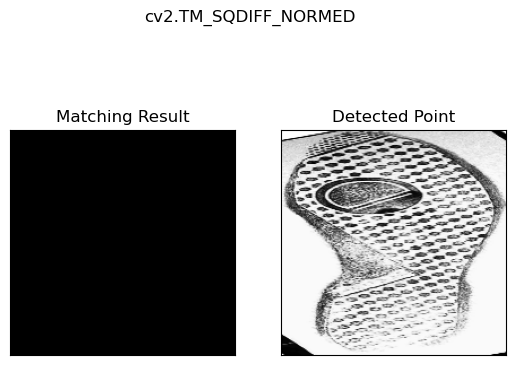

6.613779390818308e-08 6.613779390818308e-08 (0, 0) (0, 0)


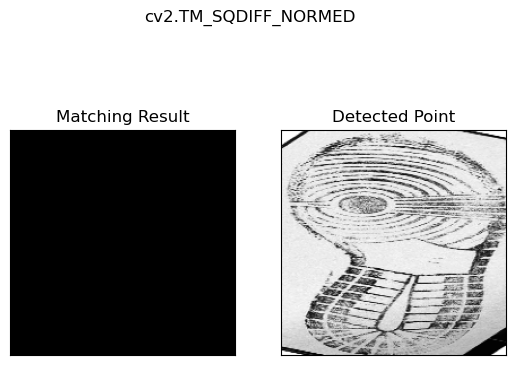

6.796030049827095e-08 6.796030049827095e-08 (0, 0) (0, 0)


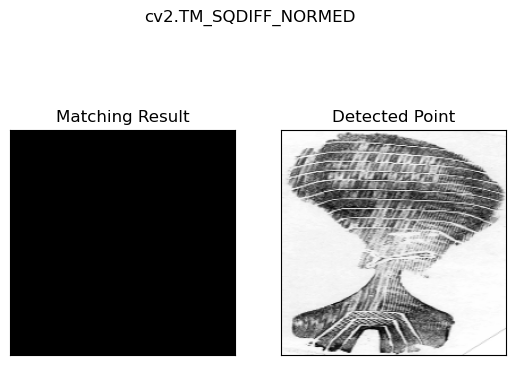

0.0 0.0 (0, 0) (0, 0)


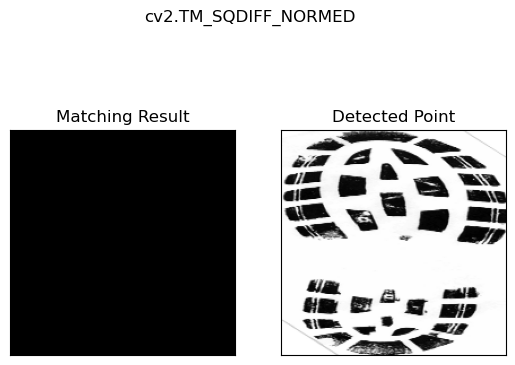

5.731019214749722e-08 5.731019214749722e-08 (0, 0) (0, 0)


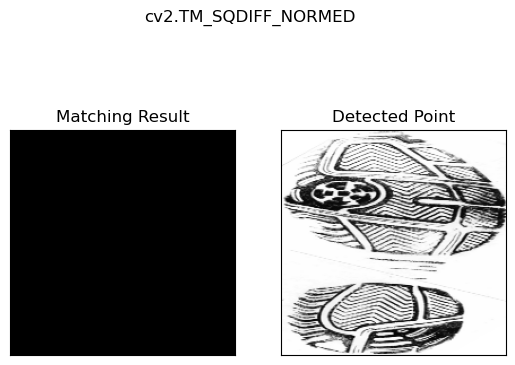

2.2953434708483655e-08 2.2953434708483655e-08 (0, 0) (0, 0)


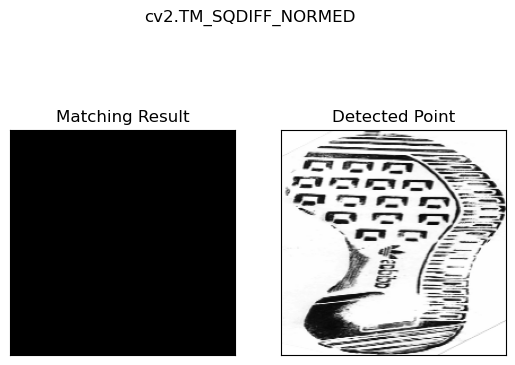

1.1932634436107037e-08 1.1932634436107037e-08 (0, 0) (0, 0)


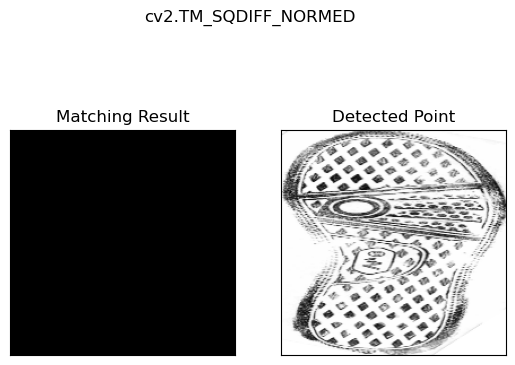

2.7534918345395454e-08 2.7534918345395454e-08 (0, 0) (0, 0)


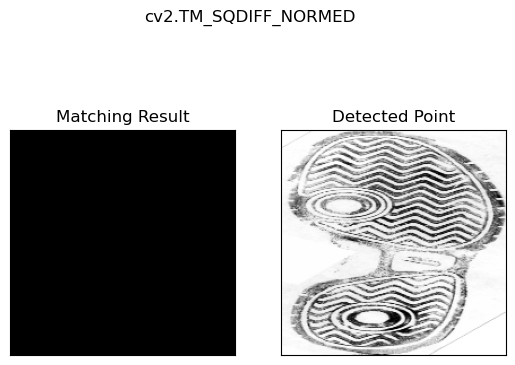

0.0 0.0 (0, 0) (0, 0)


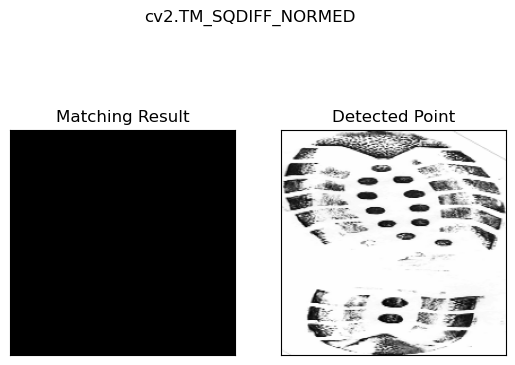

5.077194842328936e-08 5.077194842328936e-08 (0, 0) (0, 0)


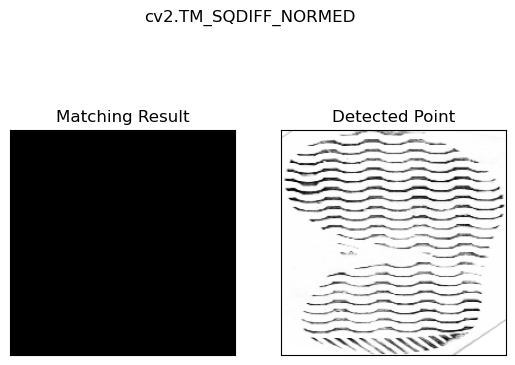

4.254829732985854e-08 4.254829732985854e-08 (0, 0) (0, 0)


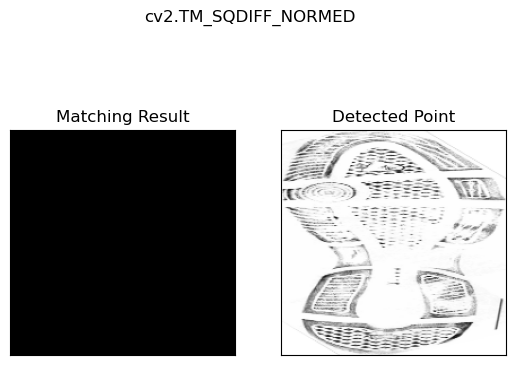

9.899636665977596e-08 9.899636665977596e-08 (0, 0) (0, 0)


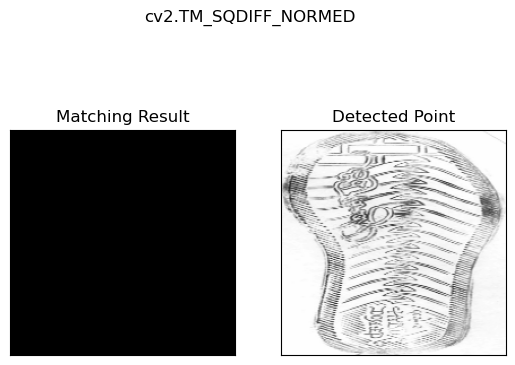

0.0 0.0 (0, 0) (0, 0)


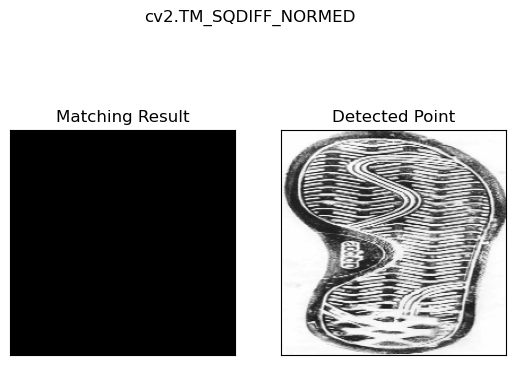

4.6064489112040974e-08 4.6064489112040974e-08 (0, 0) (0, 0)


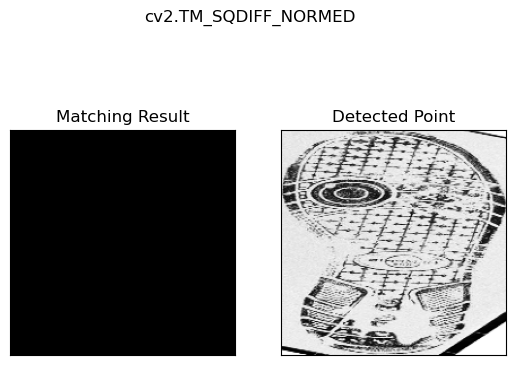

0.0 0.0 (0, 0) (0, 0)


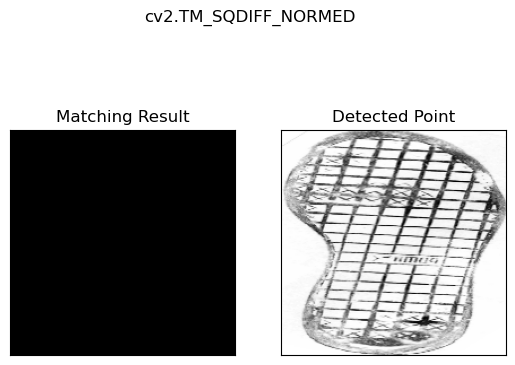

0.0 0.0 (0, 0) (0, 0)


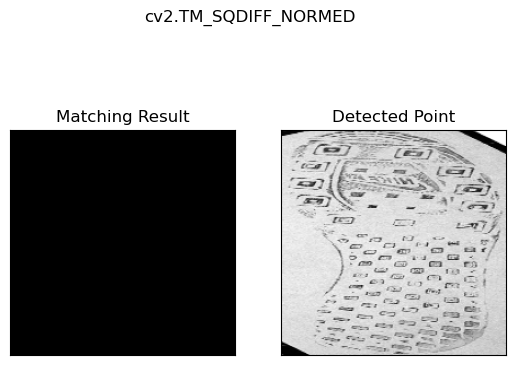

0.0 0.0 (0, 0) (0, 0)


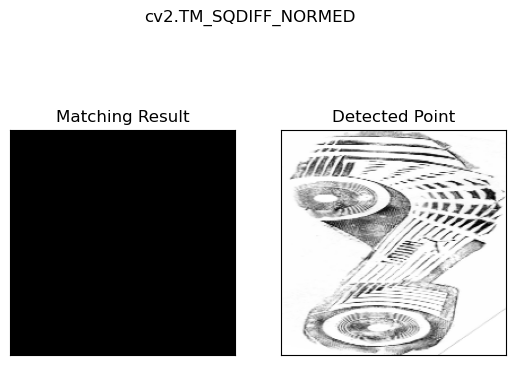

0.0 0.0 (0, 0) (0, 0)


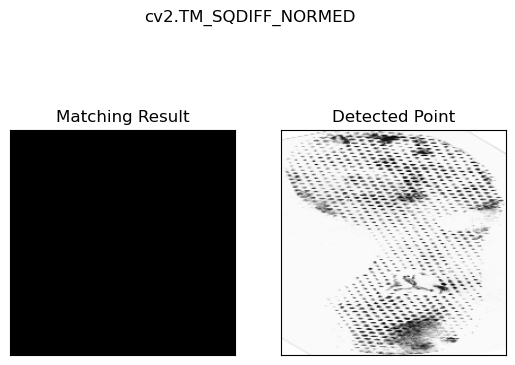

0.0 0.0 (0, 0) (0, 0)


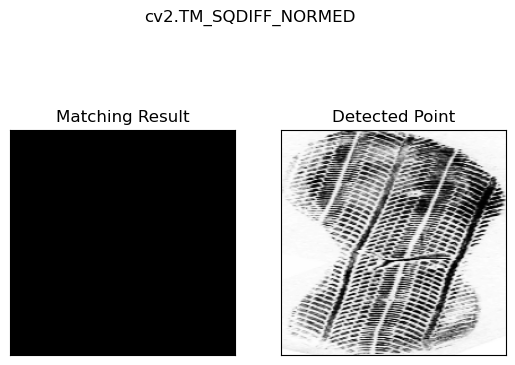

0.0 0.0 (0, 0) (0, 0)


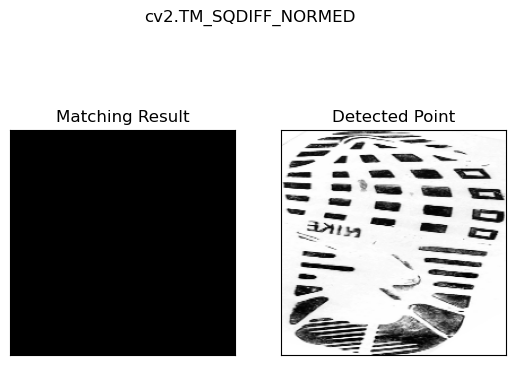

0.0 0.0 (0, 0) (0, 0)


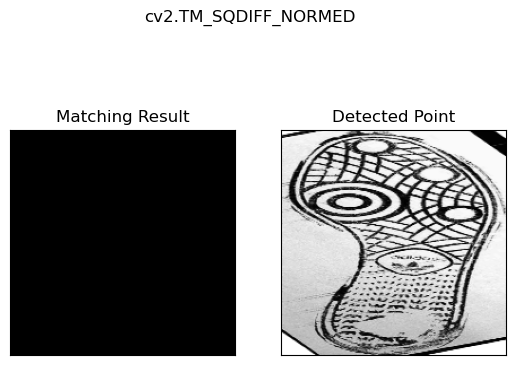

0.0 0.0 (0, 0) (0, 0)


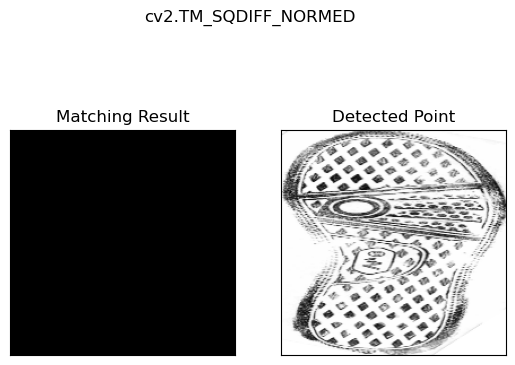

2.7534918345395454e-08 2.7534918345395454e-08 (0, 0) (0, 0)


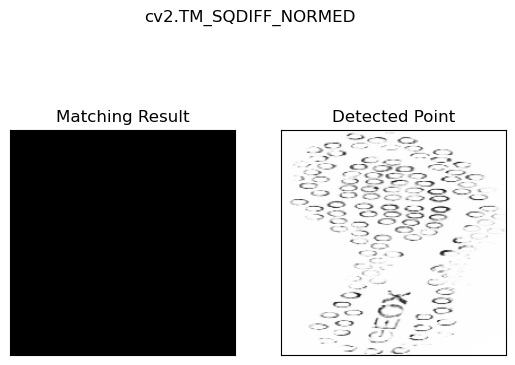

0.0 0.0 (0, 0) (0, 0)


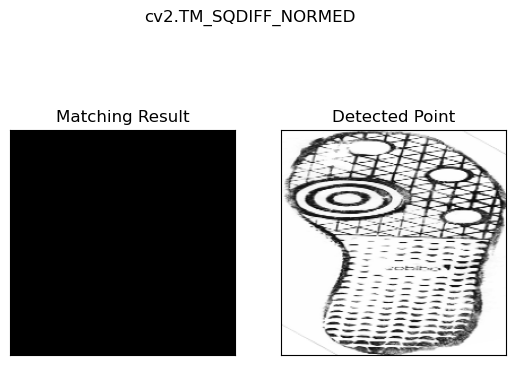

2.6699026989263075e-08 2.6699026989263075e-08 (0, 0) (0, 0)


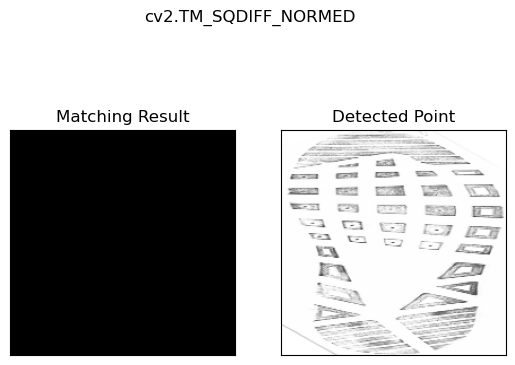

0.0 0.0 (0, 0) (0, 0)


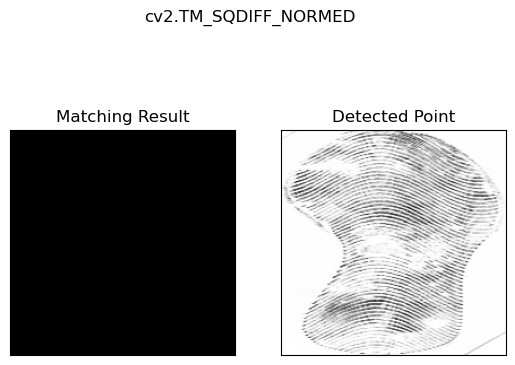

3.855512886730139e-08 3.855512886730139e-08 (0, 0) (0, 0)


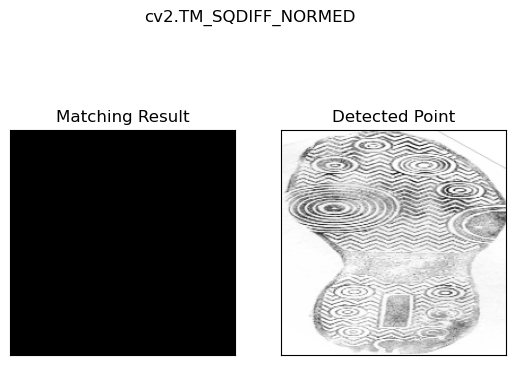

0.0 0.0 (0, 0) (0, 0)


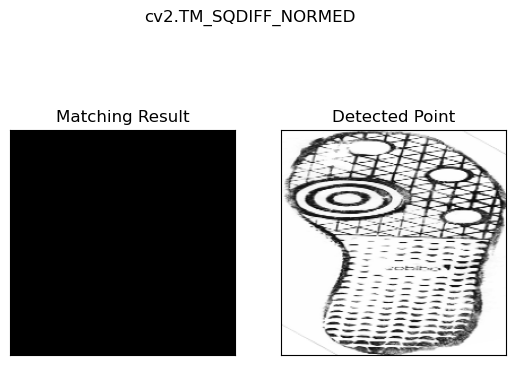

2.6699026989263075e-08 2.6699026989263075e-08 (0, 0) (0, 0)


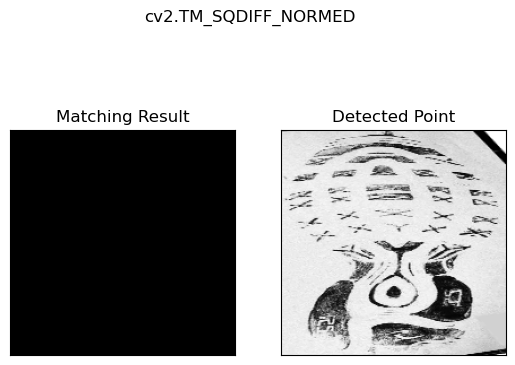

0.0 0.0 (0, 0) (0, 0)


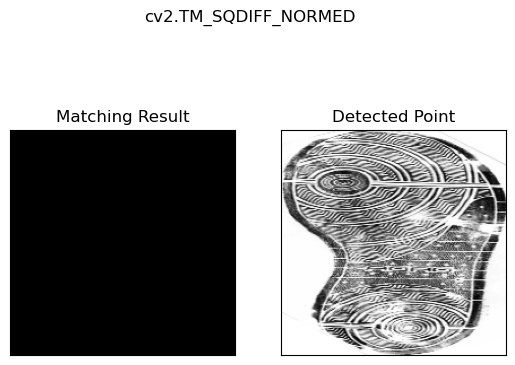

3.889837074666502e-08 3.889837074666502e-08 (0, 0) (0, 0)


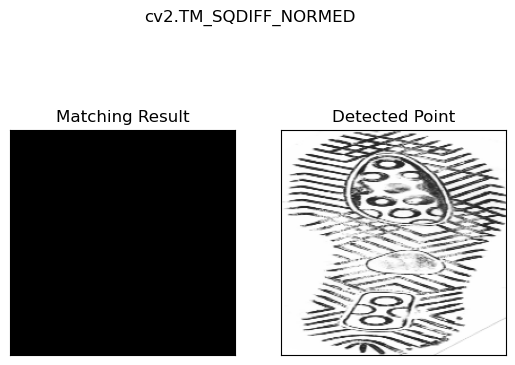

0.0 0.0 (0, 0) (0, 0)


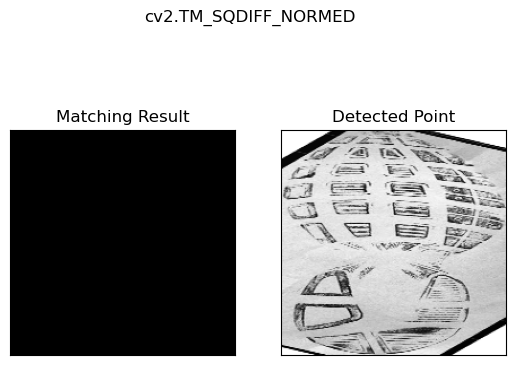

0.0 0.0 (0, 0) (0, 0)


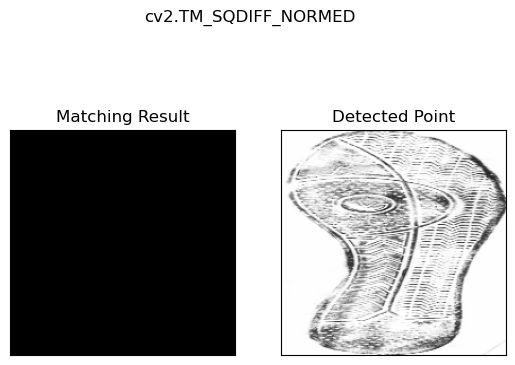

1.6717574879976382e-08 1.6717574879976382e-08 (0, 0) (0, 0)


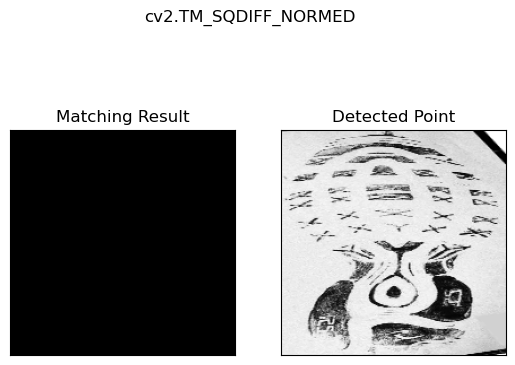

0.0 0.0 (0, 0) (0, 0)


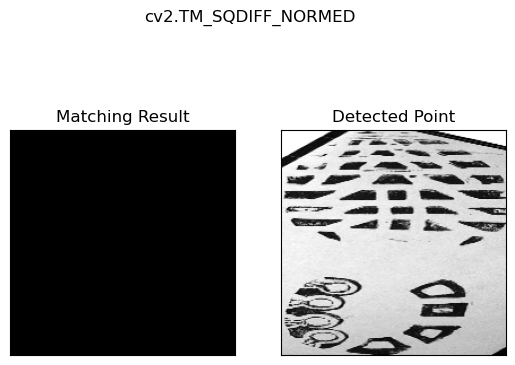

0.0 0.0 (0, 0) (0, 0)


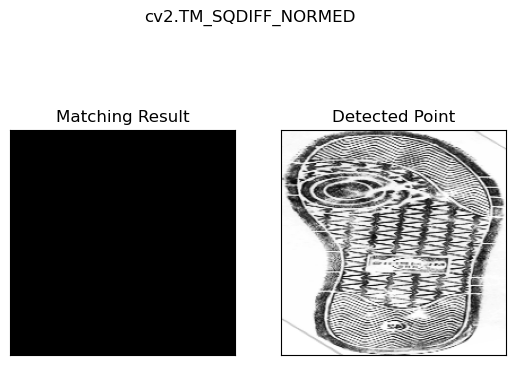

0.0 0.0 (0, 0) (0, 0)


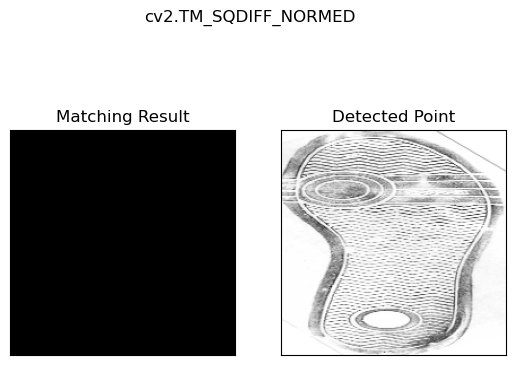

1.669969584838782e-08 1.669969584838782e-08 (0, 0) (0, 0)


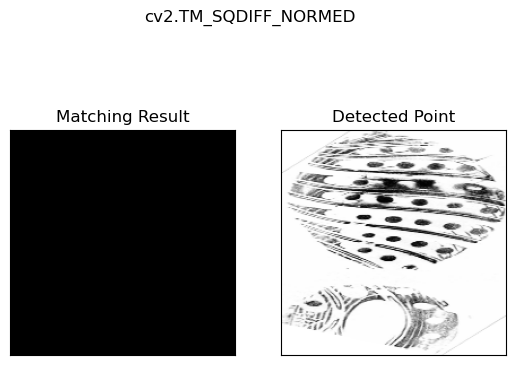

4.5697252204490724e-08 4.5697252204490724e-08 (0, 0) (0, 0)


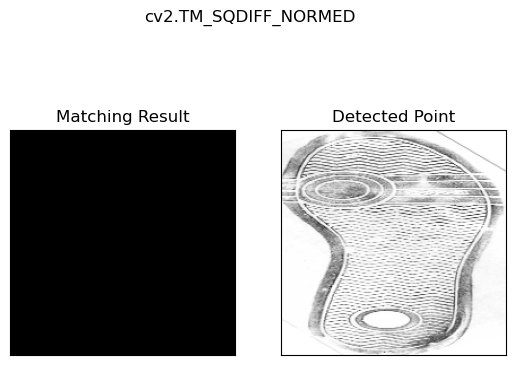

1.669969584838782e-08 1.669969584838782e-08 (0, 0) (0, 0)


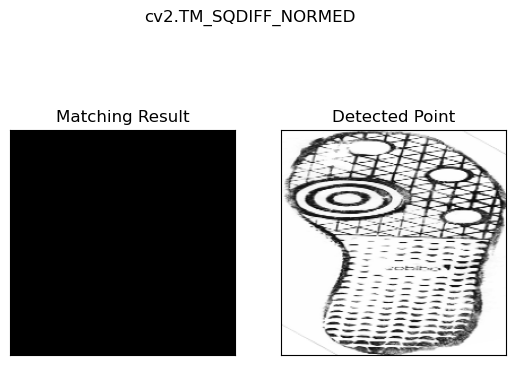

2.6699026989263075e-08 2.6699026989263075e-08 (0, 0) (0, 0)


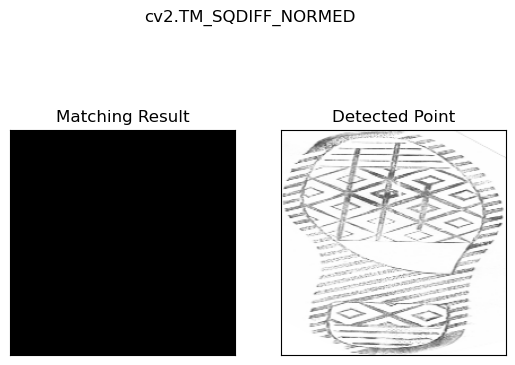

0.0 0.0 (0, 0) (0, 0)


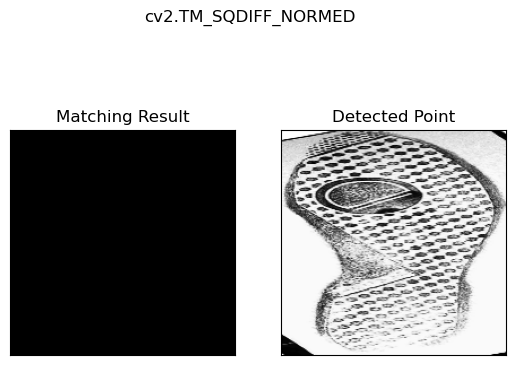

6.613779390818308e-08 6.613779390818308e-08 (0, 0) (0, 0)


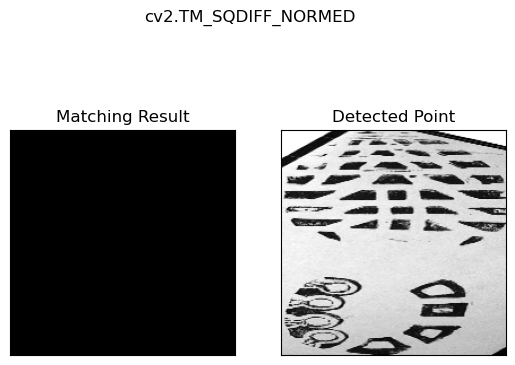

0.0 0.0 (0, 0) (0, 0)


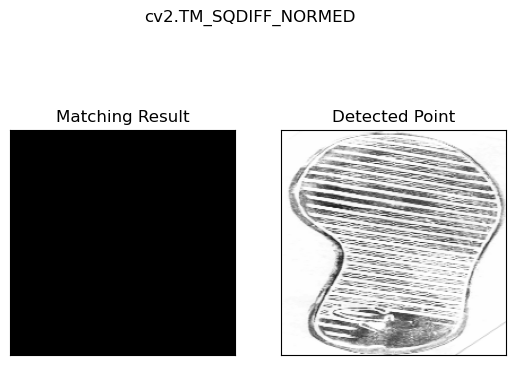

4.515050733289172e-08 4.515050733289172e-08 (0, 0) (0, 0)


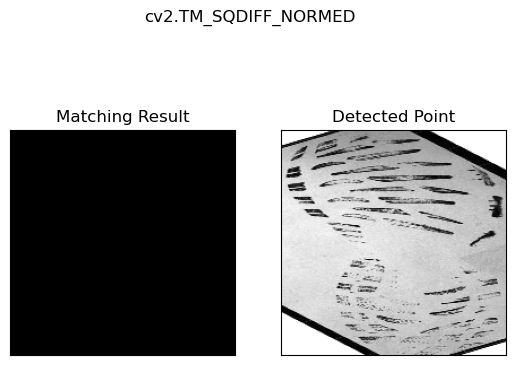

8.027317477399265e-08 8.027317477399265e-08 (0, 0) (0, 0)


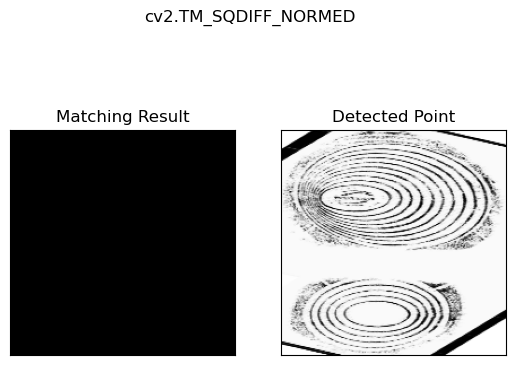

2.5742895815028533e-08 2.5742895815028533e-08 (0, 0) (0, 0)


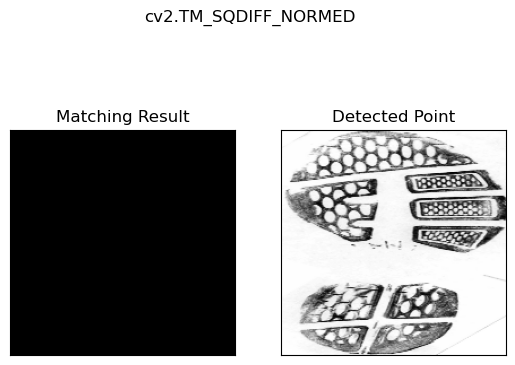

0.0 0.0 (0, 0) (0, 0)


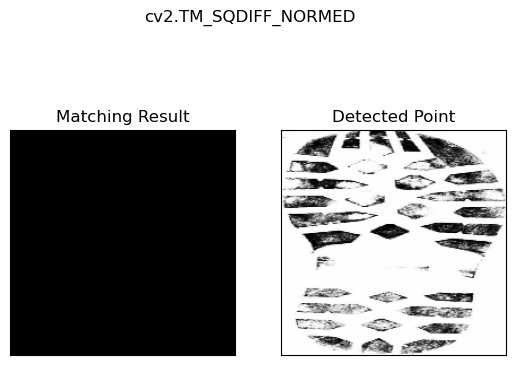

0.0 0.0 (0, 0) (0, 0)


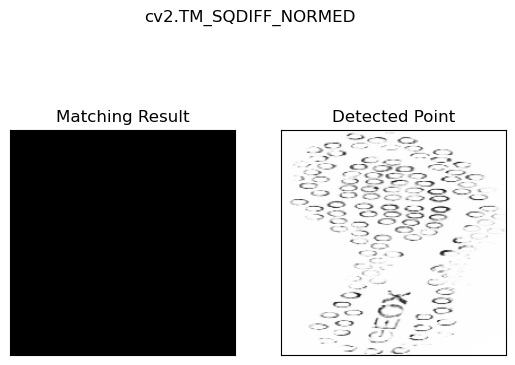

0.0 0.0 (0, 0) (0, 0)


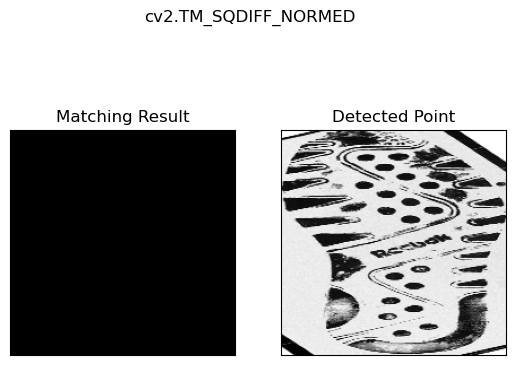

6.91563286636665e-08 6.91563286636665e-08 (0, 0) (0, 0)


In [543]:
methods = [ 'cv2.TM_SQDIFF_NORMED']

j = 0
for i in range(len(ref_img_arr)):
    for meth in methods:
        #image = cv2.imread('girl.png')
        #template = cv2.imread('girl_skirt.png')
        image = ref_img_arr[i]
        template = ref_img_arr[i]
        method = eval(meth)

        image = np.float32(image) #/ 255.0
        template = np.float32(template) #/ 255.0


        imageGray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        templateGray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)
        w, h = templateGray.shape[::-1]

        # Apply template Matching
        res = cv2.matchTemplate(imageGray,templateGray,method)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

        # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
        if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
            top_left = min_loc
        else:
            top_left = max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)

        cv2.rectangle(img,top_left, bottom_right, 255, 4)
    
        
        plt.subplot(121),plt.imshow(res,cmap = 'gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
        plt.subplot(122),plt.imshow(image,cmap = 'gray')
        plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
        plt.suptitle(meth)


        plt.show()

        #plt.imshow(imageGray)
        #plt.imshow(templateGray)
        
        print(min_val,max_val,min_loc,max_loc)
        
    print("=========================")
   

In [ ]:
plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)

    plt.show()
    
    cv2_imshow(img)

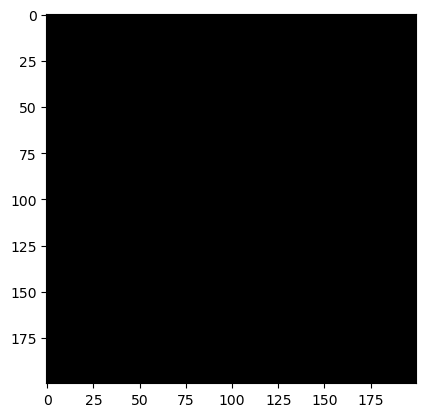

In [436]:
plt.imshow(ref_img_arr[5])

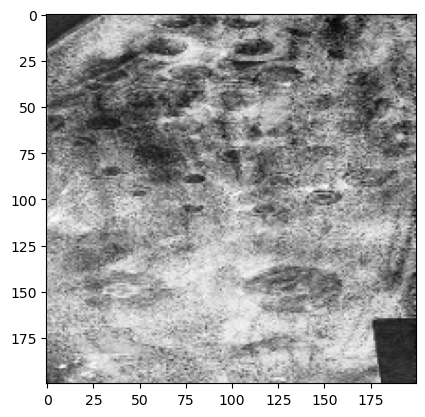

In [517]:
plt.imshow(crime_img_arr[4])

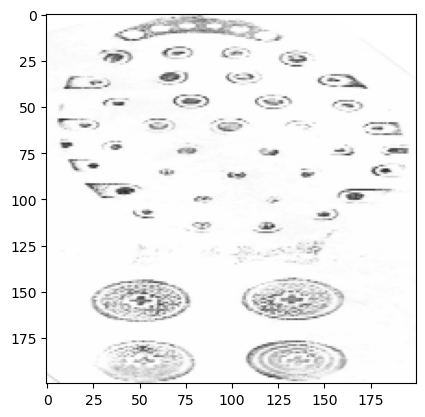

In [518]:
plt.imshow(ref_img_arr[4])